In [1]:
import whois
from fake_useragent import UserAgent
from requests import get
from os import listdir
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import math
from datetime import datetime
from pyquery import PyQuery
from random import choice, shuffle
plt.rcParams["figure.figsize"] = (20,20)
print("ok!")

ok!


In [2]:
import urllib.request
def get_page(url):
    return urllib.request.urlopen(url).read()

## This gets elite proxy from https://pypi.org/project/fake-useragent/ on every request
class Pooling(object):
	def __init__(self):
		self.proxies_url = ''

	'''returns a list of currently available elite proxies'''
	def proxy_pool(self, url = 'https://free-proxy-list.net/'):
		pq, proxies = get_page(url), []
		tr = pq('table#proxylisttable.table tbody tr')
		rows = [j.text() for j in [PyQuery(i)('td') for i in tr]]
		rows = [i for i in rows if 'elite' in i]

		for row in rows:

			row = row.split()
			data = {}
			data['ip'] = row[0]
			data['port'] = row[1]
			data['country'] = row[3]
			data['proxy'] = {
				'http' :'http://{}:{}'.format(data['ip'], data['port']),
				'https' :'https://{}:{}'.format(data['ip'], data['port'])
			}
			proxies.append(data)
		return choice(proxies)

	'''return a random list of user agents'''
	def ua_pool(self):
		ua = UserAgent()
		chromes = ua.data['browsers']['chrome'][5:40]
		shuffle(chromes)
		return choice(chromes)
print("ok!")

ok!


In [3]:

# This creates a feature vector from a URL
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url 
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now()
        
        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None
        
        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None
            
    ## URL string Features
    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy
    
    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)
    
    def urlLength(self):
        return len(self.url)
    
    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1
    
    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1
    
    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1
    
    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext
    
    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url 

    def hasHttps(self):
        return 'https:' in self.url 

    def urlIsLive(self):
        return self.response == 200
    
    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date']
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'] - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
    ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0
        
    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0
        
    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0
        
    def scriptToSpecialCharsRatio(self):
        if self.pq is not None:
            sscr = self.scriptLength()/self.specialCharacters
        else:
            sscr = 0
        return sscr
    
    def scriptTobodyRatio(self):
        if self.pq is not None:
            sbr = self.scriptLength()/self.bodyLength
        else:
            sbr = 0
        return sbr
    
    def bodyToSpecialCharRatio(self):
        if self.pq is not None:
            bscr = self.specialCharacters()/self.bodyLength
        else:
            bscr = 0
        return bscr
        
    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        return data
print("ok!")

ok!


In [4]:
data = pd.read_csv('../data/scanned_data.csv')
data=pd.DataFrame(data)
print("ok!")

ok!


In [5]:
objects = [i for i in data.columns if 'object' in str(data.dtypes[i])]
booleans = [i for i in data.columns if 'bool' in str(data.dtypes[i])]
ints = [i for i in data.columns if 'int' in str(data.dtypes[i]) or 'float' in str(data.dtypes[i])]
print("ok!")

ok!


ok!


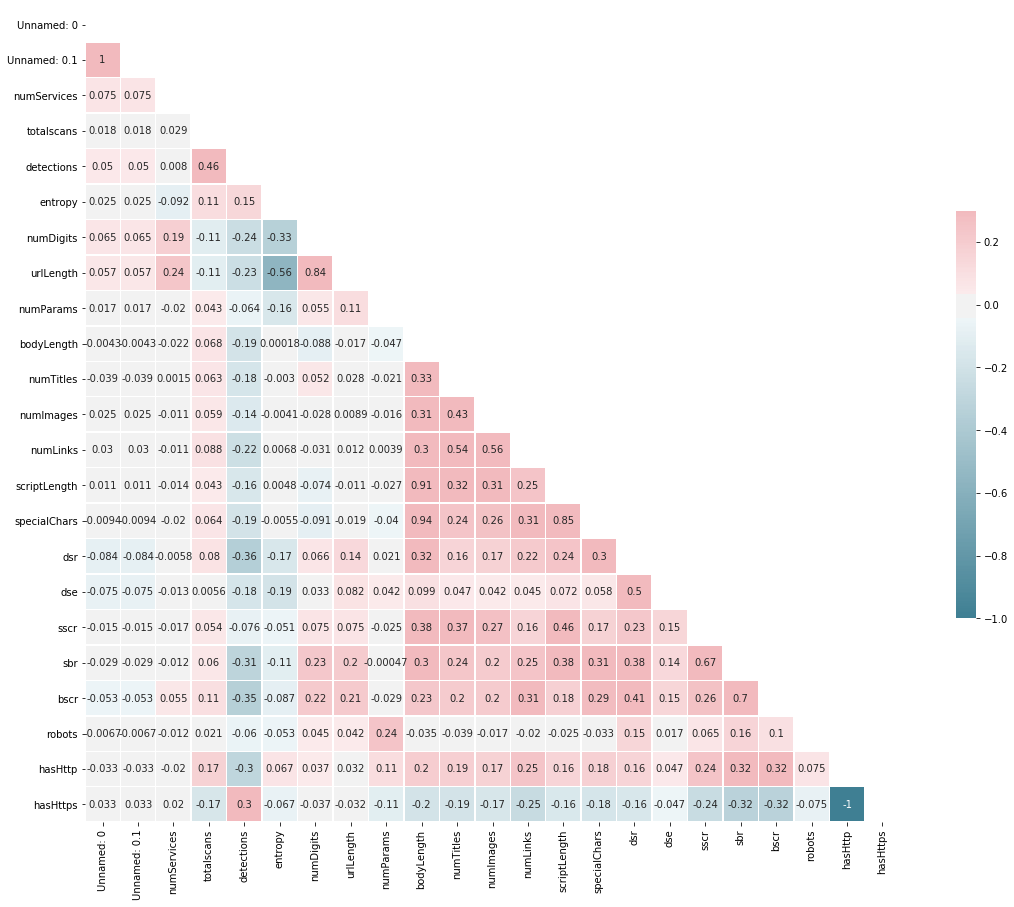

In [6]:
corr = data[ints+booleans].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

print("ok!")


In [7]:
def dropMultiCorrelated(cormat, threshold):
    ## Define threshold to remove pairs of features with correlation coefficient greater than 0.7 or -0.7
    threshold = 0.7

    # Select upper triangle of correlation matrix
    upper = cormat.abs().where(np.triu(np.ones(cormat.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    for d in to_drop:
        print("Dropping {}....".format(d))
    return to_drop

data2 = data[corr.columns].drop(dropMultiCorrelated(corr, 0.7), axis=1)
print("ok!")


Dropping Unnamed: 0.1....
Dropping urlLength....
Dropping scriptLength....
Dropping specialChars....
Dropping bscr....
Dropping hasHttps....
ok!


In [8]:
predictor_columns = data2.columns
d = data2[predictor_columns]
x, y = d[predictor_columns], data['vt_class']

print("ok!")

ok!


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)

print("ok!")

ok!


In [10]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
print("ok!")


ok!


/Users/lidayuan/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


ok!


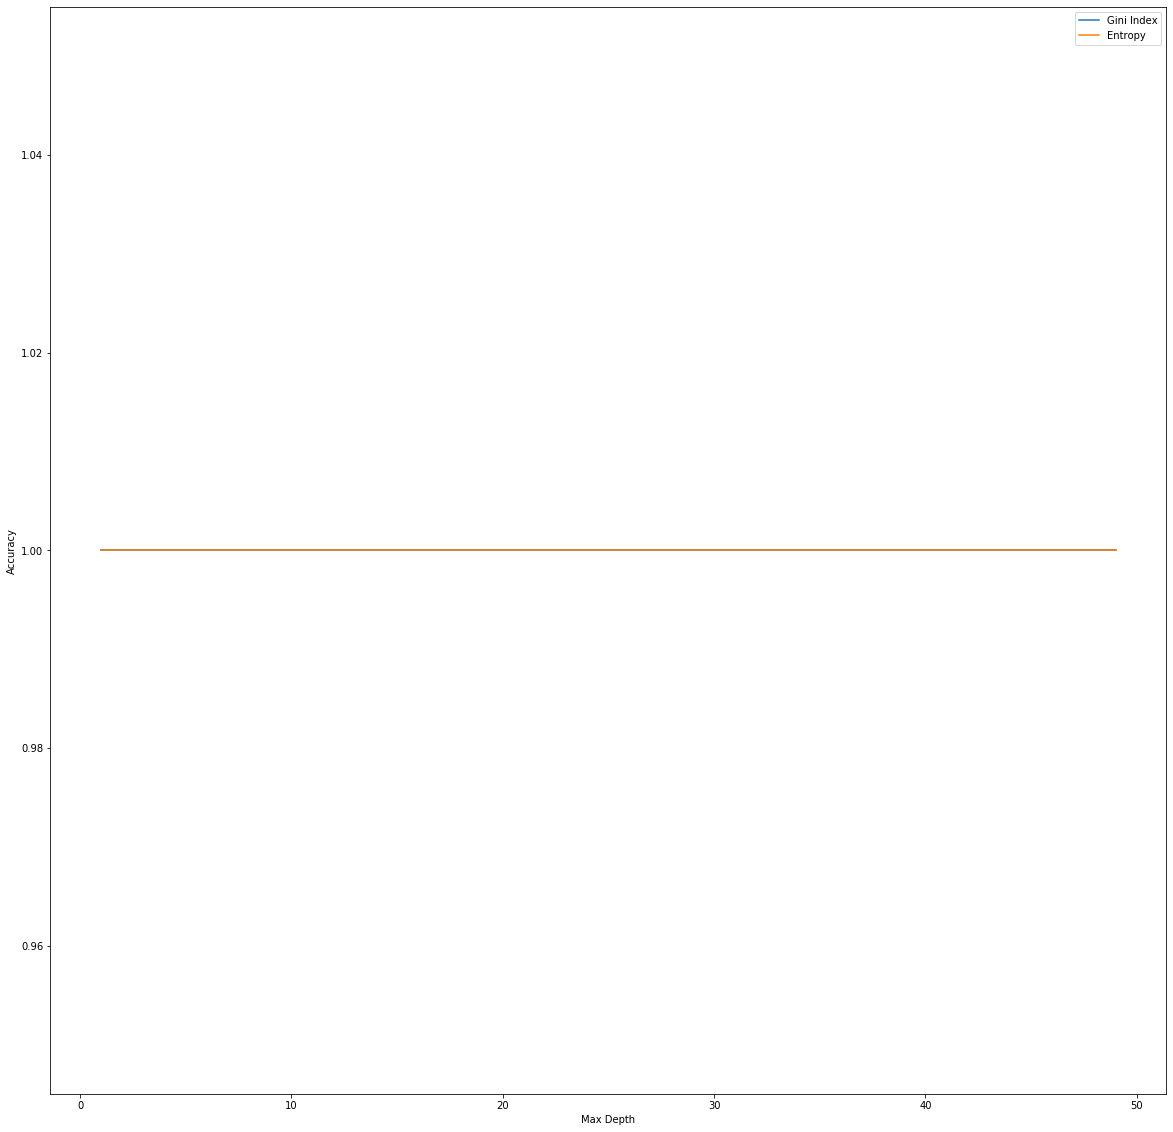

In [11]:
maxd, gini, entropy = [], [], []
for i in range(1,50):
    ###
    dtree = tree.DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    gini.append(accuracy_score(y_test, pred))
    
    ####
    dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    entropy.append(accuracy_score(y_test, pred))
    
    ####
    maxd.append(i)
    
####
d = pd.DataFrame({'gini':pd.Series(gini), 'entropy':pd.Series(entropy), 'max_depth':pd.Series(maxd)})
# visualizing changes in parameters
plt.plot('max_depth','gini', data=d, label='Gini Index')
plt.plot('max_depth','entropy', data=d, label='Entropy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
print("ok!")


In [12]:
###create decision tree classifier object
DT = tree.DecisionTreeClassifier(criterion="gini", max_depth=4)
##fit decision tree model with training data
DT.fit(X_train, y_train)
##test data prediction
DT_expost_preds = DT.predict(X_test)
print("ok!")


ok!


In [13]:
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X_train.columns, class_names=DT.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

print("ok!")


ok!
